In [115]:
%load_ext autoreload
%autoreload 2

import numpy as np
import opt_einsum as oe
import cartesian_contractions as tc # import the functions that I've written
import torch

import string

from math import factorial as fact
from scipy.stats import ortho_group



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Types of tensor *wirings*

We want to create a function that find all possible wirings (like in the following image). It would be great to add in `tikz`/`quimb`.



<img src="https://files.slack.com/files-tmb/T7QL50LUD-F04SB775S87-199fcd6ab5/img_5386_720.png"/>
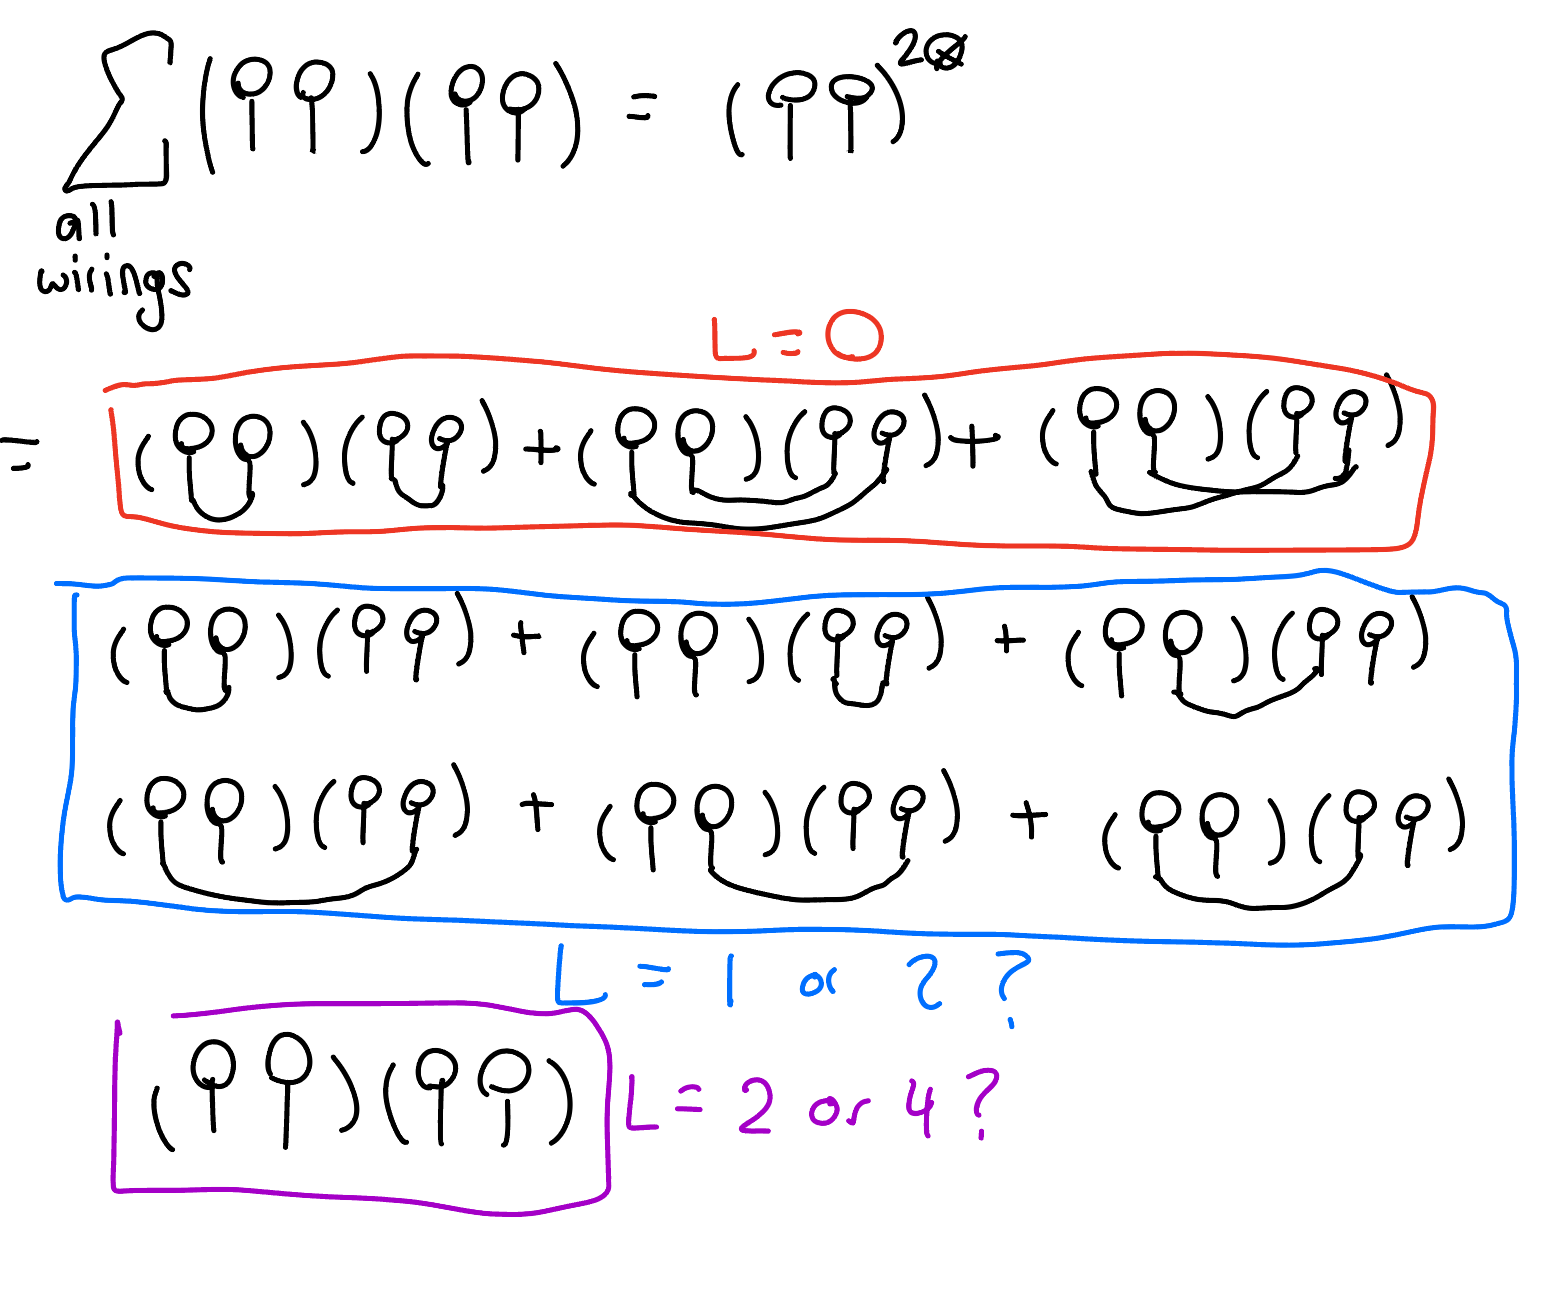

# How many contractions are there? 

A tensor of rank-$n$ has $n$ different indices e.g. scalars are rank-$0$ ($s$), vectors are rank-$1$ ($v_i$) and matrices are rank-$2$ ($M_{ij}$). It is possible to *contract* over a pair of indices setting two indices to the same letter and summing over them. For example, contracting a matrix is equivalent to finding the trace, $\sum_i M_{ii}$. Contractions will decrease the rank of a tensor by $2$. 


For our problem, it is useful to know how many ways a tensor can be contracted. If a tensor is of rank $n$ (i.e. $n$ indices) there are $n$ choose $2$, $n \choose 2$ ways of doing this. Taking a second contraction, there are now $ {n-2} \choose 2$ ways. Therefore, for $k$ contractions, we find the following formula: 

$$\text{# possible contractions} = {n \choose 2} \cdot {{n-2} \choose 2} \cdots {{n - 2k} \choose 2} = \frac{n!}{(n-2)!2!} \cdot \frac{(n-2)!}{(n-4)!2!} \cdots \frac{n!}{(n-2[k-1])!2!} = \frac{n!}{(n-2k)! k! (2!)^k}$$.

PROVE THIS EXPRESSION BY INDUCTION AS DISCUSSED

Using this expression we can write a function. 

In [116]:
def count_contractions(n: int, k: int) -> int:
    
    if k > n / 2:
        return 0
    
    else:
        return int(fact(n) / (fact(n - 2*k) * fact(k) * 2**k))

In [117]:
count_contractions(n=4,k=1) # this is what we expect! 

6

In [118]:
# Using this, we can write some unittests to ensure that we are finding the correct number of contractions.
# eventually implement with the `unittest` library, but this will do for now

# def test_contractions(contractions) -> None:
    
#     assert len(contractions(n,k)) == count_contractions(n,k)


In [168]:
indices = [char for char in string.ascii_lowercase[8:]] # i -> z

list(tc.pick_pairs(n=4, k=2, indices=indices))

[(('i', 'j'), ('k', 'l')), (('i', 'k'), ('j', 'l')), (('i', 'l'), ('j', 'k'))]

# Showing invariance and equivariance

Goals: 
- Equivariant block that computes all contractions up to a given tensor-rank 
- Be able to weight the paths parametrically, see if it is possible to learn these too (via linear regression) 
- Test the n-body environment task from *GNN Dojo*

In [170]:
# take the tensor product of u_i, v_j, s_k, t_l
# in the first simple case let i=j=k=l

# u, v, s, t = np.random.randn(4,10)
# u, v # we get 4 vectors with 10 values (that are different)

u = np.arange(1,4)
v = np.arange(4,7)
s = np.arange(7,10)
t = np.arange(10,13)
p = np.arange(13,16)
q = np.arange(16,19)

indices = [char for char in string.ascii_lowercase[8:]] # i -> z

# cons_combs = list(pick_pairs(n=4, k=1, indices=indices))
#
# cons = cons_to_einsums(cons=cons_combs[0], n=4)

tensors_out = tc.tensors_to_n(n=6, max_tensor_out_rank=4, tensors_in=torch.Tensor([u,v,s,t,p,q]))

tensors_out # i.e. we have 3 L = 0 invariants and then 6 L = 2 invariants which is what we expect!

[[tensor(6094592.),
  tensor(6089408.),
  tensor(6087680.),
  tensor(5978600.),
  tensor(5967800.),
  tensor(5962400.),
  tensor(5939936.),
  tensor(5910560.),
  tensor(5906888.),
  tensor(5906996.),
  tensor(5888420.),
  tensor(5879132.),
  tensor(5887232.),
  tensor(5870384.),
  tensor(5864768.)],
 [tensor([[1770496., 1881152., 1991808.],
          [1906688., 2025856., 2145024.],
          [2042880., 2170560., 2298240.]]),
  tensor([[1730560., 1838720., 1946880.],
          [1903616., 2022592., 2141568.],
          [2076672., 2206464., 2336256.]]),
  tensor([[1705600., 1836800., 1968000.],
          [1876160., 2020480., 2164800.],
          [2046720., 2204160., 2361600.]]),
  tensor([[1662976., 1766912., 1870848.],
          [1900544., 2019328., 2138112.],
          [2138112., 2271744., 2405376.]]),
  tensor([[1639456., 1765568., 1891680.],
          [1873664., 2017792., 2161920.],
          [2107872., 2270016., 2432160.]]),
  tensor([[1603840., 1764224., 1924608.],
          [183296

In [161]:
# lets do the same as above but test the rotational invariance equivaraince properties
# we can do this via rotating the input tensors by some random amount

Q = ortho_group.rvs(3)

print(u.dot(v))

tensors_in2 = [Q @ u, Q @ v, Q @ s, Q @ t]

print((Q @ u).dot(Q @ v)) # we see that simple properties like the dot product are left unchanged

32
31.999999999999996


In [162]:
tensors_out2 = tc.tensors_to_n(n=4, max_tensor_out_rank=2, tensors_in=torch.Tensor(tensors_in2))

for i in range(3):
    assert np.allclose(tensors_out[0][i], tensors_out2[0][i]) # as expected we have invariance!

In [163]:
# now for the L = 2 properties

for i in range(6):
    assert torch.allclose(tensors_out[1][i], tensors_out2[1][i]) # assertion error as they are not the same!

AssertionError: 

In [167]:
# need to rotate the outputs as they are equivariant (due to being matrices)

for i in range(6):
    assert torch.allclose(tensors_out[1][i], Q.T @ tensors_out2[1][i] @ Q)
    # rotating the output gives us the required equivariance!

TypeError: unsupported operand type(s) for @: 'numpy.ndarray' and 'Tensor'

In [145]:
# at this point it would be great to show an example where one path is much quicker than an alternative path

# Creating an architecture

The next steps are to create an architecture which we can then test some properties of invariance/equivariance,namely the property of rotational equivariance. Here are the steps we need to go through:

1. Prove rotational invariance/equivariance for some simple tensors to build the intuition
2. Create a method for taking in tensors and spitting out weighted linear combinations of all paths (for non-invariants is this just elementwise addition?)
2. Convert any current functions into the equivalent pytorch form
2. Put together a series of these weighted contracted tensor products (upto order $L=2$ for ea. layer)
3. Test against the rotational symmetry benchmark in *GNN Dojo*
4. Implement `opt_einsum` to find optimal paths and find ways of storing this information for a given architecture


In [123]:
def weighted_sum(weights: torch.Tensor, k:int, tensors_in: torch.Tensor(torch.Tensor)) -> torch.Tensor:

    # we can imply n and k from the tensors_in
    n = tensors_in.shape[0]
    # should be able to take away to `torch.Tensor` wrapper later
    tensors_out = torch.Tensor(tc.compute_cons_all_combs(n=n, k=k, tensors_in=tensors_in, indices=indices))

    # contract over the first index only
    # need to have a try-except clause as only works if weights dim matchs with tensors_out dim
    rem_subscripts = ''.join(indices[2:n-2*k+2])
    einsum = f'i,i{rem_subscripts}->{rem_subscripts}'
    print(einsum)
    wsum= torch.einsum(einsum, weights, tensors_out) # want to sum along the first dim

    return wsum

TypeError: expected Tensor as argument 0, but got torch._C._TensorMeta

In [124]:
weights = torch.rand(3)

weighted_sum(weights=weights, k=2, tensors_in=tensors_in)

NameError: name 'weighted_sum' is not defined

# Building the moment generator

We know from MTP the kind of feature we want to generate are moments roughly of the form

$$M^i_{\mu, \nu} \sim \sum_j \mathbf r_{ij} \otimes \cdots \nu \; \text{times} \cdots \otimes \mathbf r_{ij} $$

Now lets take the example of using tensors upto order $L = 2$ i.e. matrices. It is thought that this means we can get upto two-fold symmetry detection (explain what this is better!).

What this means for now is that we need to develop the functions used above before we can build the architecture:
1. change from `numpy` arrays to `torch` tensors
2. create a more friendly interface for turning data into invaraints/equivariants


In [323]:
x = torch.tensor([0,0])
y = torch.tensor([1,0])
r = y - x
dist = np.linalg.norm(r) # torch.linalg.norm() wasn't working

In [325]:
n = 5

tensors_in = r.repeat(n,1) # how many version of itself do we want

tc.tensors_to_n(n=n, max_tensor_out_rank=2, tensors_in=tensors_in)
# when we do this self-tp all the invariants/equivariants give the same value?

[[array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0]),
  array([1, 0])],
 [array([[[1, 0],
          [0, 0]],
  
         [[0, 0],
          [0, 0]]]),
  array([[[1, 0],
          [0, 0]],
  
         [[0, 0],
          [0, 0]]]),
  array([[[1, 0],
          [0, 0]],
  
         [[0, 0],
          [0, 0]]]),
  array([[[1, 0],
          [0, 0]],
  
         [[0, 0],
          [0, 0]]]),
  array([[[1, 0],
          [0, 0]],
  
         [[0, 0],
          [0, 0]]]),
  array([[[1, 0],
          [0, 0]],
  
         [[0, 0],
          [0, 0]]]),
  array([[[1, 0],
          [0, 0]],
  
         [[0, 0],
          [0, 0]]]),
  array([[[1, 0],
          [0, 0]],
  
         [[0, 0],
          [0, 0]]]),
  array([[[1, 0],
          [0, 0]],
  
         [[0, 0],
          [0, 0]]]),
  array([[[1, 0],
          [0, 0

# Linear regression

Here we will produce some noisy data using some of the three invariants for $n = 4, k  = 2$ with some added noise. Will first do with Moore-Penrose pseudoinverse and then will try and solve using some class and backprop (obviously overkill but good to get familiar with making a class when it is super simple)

Our equation for a straight line in matrix form is $\mathbf{y = Mx + c}$ where $x$ are the model parameters and $\mathbf M$ are the data, we can also include $\mathbf c$ in $\mathbf M$ as a column of zeros to yield $\mathbf{y = Mx}$. For a skinny matrix we have no inverse, therefore $\mathbf{x = M^+ y}$ where $\mathbf M^+$ is the Moore-Penrose pseudoinverse. By minimisation of the $2$-norm it is straightforward to show that for a $M \times N$ matrix where $M > N$ (i.e. overdetermined) the pseudoinverse is given by:
$$\mathbf M^+ = (\mathbf M^T \mathbf M)^{-1} \mathbf M ^T$$

The basis-function part takes care of itself (I think?) - just need to hstack a set of ones on the side of the data

In [352]:
# first do for single TP for two of the same matrices
# for a single point u

n = 2

u = torch.Tensor([1])
tensors_in = u.repeat(n,1)
tc.tensors_to_n(n=n, max_tensor_out_rank=1, tensors_in=tensors_in) # nice -> there is just one invariant, as expected :-)

[[1.0]]

In [405]:
y = torch.zeros(100)
u_phi = torch.zeros(100)

for i in range(100): # this should be done vectorised -> not sure how with `tc.tensors_to_n` which isn't vectorised

    # both creating outputs of the basis functions and fake data generation
    u = torch.Tensor([0.1*i])
    tensors_in = u.repeat(n,1)
    y[i] = 2*torch.Tensor(tc.tensors_to_n(n=n, max_tensor_out_rank=1, tensors_in=tensors_in)) + 1 + torch.randn(1)
    u_phi[i] = torch.Tensor(tc.tensors_to_n(n=n, max_tensor_out_rank=1, tensors_in=tensors_in))
    # y = 2*x**2 + 1  + noise lets see if our linear regression can figure this out!

# ah, the perfect squares!
# y = y.reshape(100,1)

tensor([  1.3437,   0.9537,  -0.6153,   2.4892,   2.6124,   2.8448,   1.4491,
          1.7029,   0.9183,   3.5758,   3.4527,   3.7293,   2.9868,   4.7780,
          3.6436,   5.2320,   4.2784,   8.2160,   8.3947,   7.2011,   8.0127,
          9.2784,   9.6145,  11.8012,  15.0681,  13.8950,  14.8962,  14.7171,
         17.8971,  18.5584,  19.1464,  17.5153,  21.0893,  23.1002,  23.5262,
         23.4935,  26.7666,  27.0414,  29.2210,  31.2154,  32.5848,  34.6997,
         37.2090,  39.8339,  40.2047,  41.1486,  42.8042,  45.5402,  47.6463,
         49.2810,  53.0191,  53.0018,  56.6548,  56.3939,  60.2680,  62.2236,
         63.0881,  65.3369,  67.3810,  70.9451,  72.7382,  73.5145,  79.1212,
         80.1458,  82.0432,  86.0275,  89.0292,  91.5095,  92.3751,  97.7160,
         99.2935, 103.7705, 102.7096, 108.9723, 109.2618, 112.1263, 117.3682,
        119.6736, 123.6528, 124.5087, 129.2605, 131.7545, 137.0529, 138.5599,
        140.0937, 146.1397, 148.6103, 152.9676, 155.9452, 159.83

In [406]:
ones = torch.ones(100,1)
data = torch.hstack((u_phi.reshape(100,1), ones))

data

tensor([[0.0000e+00, 1.0000e+00],
        [1.0000e-02, 1.0000e+00],
        [4.0000e-02, 1.0000e+00],
        [9.0000e-02, 1.0000e+00],
        [1.6000e-01, 1.0000e+00],
        [2.5000e-01, 1.0000e+00],
        [3.6000e-01, 1.0000e+00],
        [4.9000e-01, 1.0000e+00],
        [6.4000e-01, 1.0000e+00],
        [8.1000e-01, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.2100e+00, 1.0000e+00],
        [1.4400e+00, 1.0000e+00],
        [1.6900e+00, 1.0000e+00],
        [1.9600e+00, 1.0000e+00],
        [2.2500e+00, 1.0000e+00],
        [2.5600e+00, 1.0000e+00],
        [2.8900e+00, 1.0000e+00],
        [3.2400e+00, 1.0000e+00],
        [3.6100e+00, 1.0000e+00],
        [4.0000e+00, 1.0000e+00],
        [4.4100e+00, 1.0000e+00],
        [4.8400e+00, 1.0000e+00],
        [5.2900e+00, 1.0000e+00],
        [5.7600e+00, 1.0000e+00],
        [6.2500e+00, 1.0000e+00],
        [6.7600e+00, 1.0000e+00],
        [7.2900e+00, 1.0000e+00],
        [7.8400e+00, 1.0000e+00],
        [8.410

In [414]:
torch.einsum('ij,j->i', torch.linalg.pinv(data), y)# this is the exact thing we expect to see! can we do the same for n = 4 k = 2 where we have 3 basis functions?
# although for low n these invariants are quite simple functions of their inputs, once using higher n and different inputs (i.e. not u \otimes u)

tensor([2.0040, 0.9248])

This here, although quite cool, is not necessarily the most useful for building a `CartesianTensor` class that can be used to test against the rotational symmetry dataset. (i.e. the fiddly stuff that I've had to do should be solved by the `CartesianTensor.forward()` method)

In [573]:
arr = np.random.uniform(size=(3,3))

# same results!
assert shortest_path(arr=arr) == shortest_path_padding(arr=arr)

In [574]:
%timeit shortest_path(arr=arr)
%timeit shortest_path_padding(arr=arr)

5.98 µs ± 35.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
23.7 µs ± 2.43 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [582]:
a = np.random.randn(3,3)
b = np.random.randn(3)

%timeit contract('ij,j->i',a,b)
%timeit np.einsum('ij,j->i',a,b)

23.1 µs ± 1.94 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.21 µs ± 36.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


# Saving paths using `opt_einsum`

In [20]:
dim = 30
C = np.random.rand(dim, dim)

tor = torch.Tensor(5*[C])

# np.einsum is slow!
%timeit np.einsum('ii,jj,kk,ll,mm->', C, C, C, C, C)
%timeit oe.contract('ii,jj,kk,ll,mm->', C, C, C, C, C)
%timeit torch.einsum('ii,jj,kk,ll,mm->', *tor) # we see that torch.einsum already uses `opt_einsum` !

/var/folders/n6/k7q2_21s0hg6l8hvv7cjnrh00000gn/T/ipykernel_81631/3329846605.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  tor = torch.Tensor(5*[C])


120 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
396 µs ± 5.58 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
404 µs ± 583 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
oe.contract_path('ii,jj,kk,ll,mm->', C, C, C, C, C)

([(0, 1), (0, 3), (0, 2), (0, 1)],
   Complete contraction:  ii,jj,kk,ll,mm->
          Naive scaling:  5
      Optimized scaling:  2
       Naive FLOP count:  9.720e+7
   Optimized FLOP count:  1.980e+3
    Theoretical speedup:  4.909e+4
   Largest intermediate:  1.000e+0 elements
 --------------------------------------------------------------------------------
 scaling        BLAS                current                             remaining
 --------------------------------------------------------------------------------
    2              0                jj,ii->                           kk,ll,mm,->
    1              0                  ,kk->                              ll,mm,->
    1              0                  ,ll->                                 mm,->
    1              0                  ,mm->                                    ->)

In [112]:
def optimised():
    K = np.einsum('jj,ii->', C, C)
    K = np.einsum(',kk->', K,C)
    K = np.einsum(',ll->', K,C)
    K = np.einsum(',mm->', K,C)
    return K

%timeit optimised()

6.67 µs ± 573 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [18]:
# this is how we save paths!
expr = oe.contract_expression("ii,jj,kk,ll,mm->", (dim,dim), (dim,dim), (dim,dim), (dim,dim), (dim,dim))

%timeit expr(C,C,C,C,C)

15.1 µs ± 63 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# MISC PROGRAMMING

In [180]:
def shortest_path(arr: np.array) -> np.array:

    x, y = arr.shape

    cost = np.zeros(arr.shape)

    for i in range(y):
        for j in range(x):

            if i == 0 and j == 0:
                cost[i,j] += arr[i,j]

            elif i == 0:
                cost[i,j] += cost[i,j-1] + arr[i,j]

            elif j == 0:
                cost[i,j] += cost[i-1,j] + arr[i,j]

            else:
                cost[i,j] += np.minimum(cost[i-1,j], cost[i,j-1]) + arr[i,j]

    return cost[-1,-1]

In [181]:
def shortest_path_padding(arr: np.array) -> np.array:

    # for shape of cost matrix
    x, y = arr.shape
    cost = np.zeros(arr.shape)
    cost = np.pad(cost, ((1,0), (1,0)), constant_values=np.inf)

    # pad the array with infinitys (no edge cases!)
    # pad_arr = np.pad(arr, ((1,0), (1,0)), constant_values=np.inf)

    x, y = cost.shape

    for i in range(1,y):
        for j in range(1,x):

            if i == 1 and j == 1:
                cost[i,j] = arr[i-1,j-1]
            else:
                cost[i,j] += np.minimum(cost[i-1,j], cost[i,j-1]) + arr[i-1,j-1]

    # remove padding
    # cost = cost[1:,1:]

    return cost[-1,-1]

In [182]:
arr = np.random.rand(3,3)

shortest_path(arr=arr)

1.3409877396183925

In [183]:
arr

array([[0.78019831, 0.95320868, 0.90873692],
       [0.0782855 , 0.01511177, 0.83286226],
       [0.48522047, 0.0781997 , 0.38919246]])